# Домашняя работа 6. Классификация.

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.
4. Пришлите на почту ml-teachers ссылку на этот файл в вашем репозитории.
5. В теме письма указать `ML Homework #6: Name Surname`. Если тема будет неправильная, то задание не будет проверено.

**Дедлайн**: 4.12.2017 01:00 OMSK

    После дедлайна можно сдать, но вы получите штраф по баллам в рейтинге.

**Рассылка решений**: 9.12.2017 17:00 OMSK

    После рассылки задания совсем не имеют веса.

### Полезная литература

- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Коллаборативная фильтрация - рекомендательная система](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F)
- [Метрики расстояний - косинусная, минковского, проклятье размерности ](http://www.machinelearning.ru/wiki/images/9/9a/Sem1_knn.pdf)
- [Offtop: метрики качества рекомендаьельных систем](https://habrahabr.ru/company/dca/blog/281066/)
- [Байесовский классификатор](http://www.machinelearning.ru/wiki/index.php?title=%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80)
- [Интересная статья про спам/не спам](https://habrahabr.ru/post/252265/)

Если вам понравилась задача распознавания текстов, то вот подборочка:

- [библиотека Gensim](https://radimrehurek.com/gensim/)
- [библиотека nltk](http://www.nltk.org/)
- [Лекция про word2vec 🔥](https://www.youtube.com/watch?v=oBb9aFmp0Hs)
- [Лекция Векторные представления слов и документов 🔥](https://www.youtube.com/watch?v=hiDBnEyoZS4)

В этой практике мы будем использовать алгоритмы k ближайших соседей и наивный байес для задач классификации и не только. 

## kNN - ближайшие соседи

Мы уже видели с вами на практиках и лекциях как применять алгоритм ближайших соседей. Мы даже видели с вами на примере классификации sms-спама, что этот метрический алгоритм не всегда справляется с многомерными данными. Поэтому в домашнем задании мы с вами сконцентриуемся на другой задаче, котоую можно решить этим алгоритмом: вы построите рекомендательную систему.

### Рекомендательная система

Будем использовать известный нам [датасет с оценками фильмов](http://www.cs.umn.edu/GroupLens). Только в этот раз мы не будем кластеризовывать жанры, а будем рекомендовать похожие фильмы, основываясь на оценках других пользователей. То есть мы будем по факту предсказывать предпочтение нового пользователя на основе других.

Для рекомендательной системы в датасете в объектами будут пользователи, а признаками - оценки фильма данным пользователем.

![](https://i.imgur.com/hn3xjZl.png)

Мы будем использовать метрический алгоритм для поиска ближайших соседей, тем самым рекомендовать фильмы близкие к данному.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
movies = pd.read_csv('data/imdb_movies.csv.gz', index_col='movieId')
ratings = pd.read_csv('data/imdb_ratings.csv.gz')

print(movies.shape)
print(ratings.shape)

(9125, 2)
(100004, 4)


In [3]:
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


### 1.1 Поиск популярных фильмов (3 балла)

Среди всех фильмов есть не популярные, для которых выставлена 1-2 оценки. Такого количества данных не достаточно, поэтому нужно срезать много фильмов с маленьким числом отзывов.

Посчтитайте количество оценок для каждого фильма.

In [15]:
popularity = ratings.groupby('movieId').count()['userId']
popularity.name = 'count'
popularity

movieId
1         247
2         107
3          59
4          13
5          56
         ... 
161944      1
162376      1
162542      1
162672      1
163949      1
Name: count, Length: 9066, dtype: int64

Выведите сводную статистику по количеству оценок фильмов. (общее число фильмов, среднее количество оценок, дисперсию, квантили)

In [19]:
popularity.describe()

count    9066.000000
mean       11.030664
std        24.050800
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       341.000000
Name: count, dtype: float64

Как мы видим `75%` квантиль показывет, что `75%` фильмов имело очень мало оценок. Нам столько будет недостаточно. Посчтитайте квантили в диапазоне от `75%` до `100%` с шагом в `1%`. Выберите тот квантиль, при котором количество оценок равно 20. Напишите какой это квантиль. Напишите сколько всего фильмов останется, если отбросить все фильмы у которых рейтинг меньше этого квантиля.

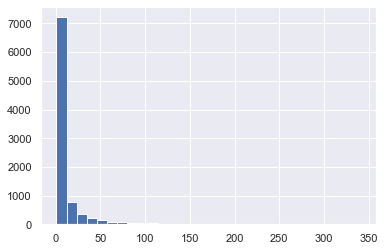

In [23]:
sns.set()
plt.hist(popularity, 30)
plt.show()

In [147]:
from IPython.display import display, Markdown as md

display(md('**q quantile**'))
search = -1
for q in range(75, 101, 1):
    if popularity.quantile(q / 100) == 10:  # я хочу не 20, а 10
        search = q / 100
    print(q, popularity.quantile(q / 100))

**q quantile**

75 9.0
76 10.0
77 10.0
78 11.0
79 12.0
80 13.0
81 14.0
82 15.0
83 16.0
84 17.0
85 19.0
86 20.0
87 22.0
88 23.0
89 25.0
90 28.0
91 31.0
92 34.0
93 38.0
94 44.0
95 49.0
96 58.0
97 69.04999999999927
98 89.0
99 123.0
100 341.0


In [148]:
search

0.77

In [149]:
left = popularity[popularity > popularity.quantile(search)]
print(f'Останется {len(left)} фильмов')

Останется 2083 фильмов


### 1.2 Соединяем таблицы (1 балл)

Будет немного не удобно искать фильмы по их идентификаторам, нам нужны названия. Поэтому соедините две таблицы `ratings` и `movies` по `movieId` и отфильтруйте отзывы на редкие фильмы, которые мы нашли в предыдущем шаге. Выведите первые 5 элементов полученного датасета.

In [150]:
df = movies.join(ratings.set_index('movieId'), on='movieId').loc[left.index.values]
df.head(5)

,title,genres,userId,rating,timestamp
movieId,,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,3.0,8.518667e+08
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9.0,4.0,9.386292e+08
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13.0,5.0,1.331380e+09
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.0,9.979383e+08
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19.0,3.0,8.551901e+08


### 1.3 Матрица Фильмы-Пользователи

В нашем случае мы будем искать похожие фильмы, поэтому сделайте из датасета оценок матрицу, где в строках фильмы, в колонках пользователи, а в ячейках оценки. Пропущенные значение, то есть отсутсвие оценки, заполните 0.

Для увеличения скорости выполнения алгоритма ближайших соседей примените функцию [`scipy.sparse.csc_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html),  которая создаст плотное представление нашей разреженой матрицы.

In [151]:
from scipy.sparse import csc_matrix

df = df.pivot(index='title', columns='userId', values='rating').fillna(0)
matrix = csc_matrix(df)

### 1.4 Тренировка модели рекомендаций 

Так как по сути у нас нет каких-то меток классов, мы будем использовать алгоритма без учителя [`sklearn.neighbors.NearestNeighbors`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html). Научите его по данным нашей матрицы пользователей-фильмов и напишите **функцию**, принимающую на вход название фильма и возвращающую список из 6 рекомендованых фильмов, начиная от более похожего.

Для определения "похожести" двух фильмов мы будем использовать косинусную меру, вместо евклидова или минковского:

$$\LARGE cos(\overrightarrow{x},\overrightarrow{y}) = \frac{\overrightarrow{x} \cdot \overrightarrow{y}}{||\overrightarrow{x}|| \times ||\overrightarrow{y}||}$$

In [66]:
from sklearn.neighbors import NearestNeighbors as NN

In [152]:
def similar(name='Pulp Fiction (1994)', n=6):
    model = NN(metric='cosine')
    model.fit(matrix)
    neis = model.kneighbors([df.loc[name]], n+1, return_distance=False)
    return df.iloc[neis.flatten()].drop(name).index.tolist()

Выведите рекомендации для фильмов:
- `Pulp Fiction (1994)`
- `Star Wars: Episode V - The Empire Strikes Back (1980)`
- `Lord of the Rings: The Two Towers, The (2002)`

In [153]:
similar('Pulp Fiction (1994)')

['Silence of the Lambs, The (1991)',
 'Shawshank Redemption, The (1994)',
 'Seven (a.k.a. Se7en) (1995)',
 'Forrest Gump (1994)',
 'Usual Suspects, The (1995)',
 'Jurassic Park (1993)']

In [154]:
similar('Star Wars: Episode V - The Empire Strikes Back (1980)')

['Star Wars: Episode IV - A New Hope (1977)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
 'Indiana Jones and the Last Crusade (1989)',
 'Back to the Future (1985)',
 'Terminator, The (1984)']

In [155]:
similar('Lord of the Rings: The Two Towers, The (2002)')

['Lord of the Rings: The Return of the King, The (2003)',
 'Lord of the Rings: The Fellowship of the Ring, The (2001)',
 'Pirates of the Caribbean: The Curse of the Black Pearl (2003)',
 'Matrix, The (1999)',
 'Spider-Man (2002)',
 'Shrek (2001)']

### 1.5 Как посчитать качество рекомендации?

Как посчитать качество нашей классификации? У нас нет учителя, нет отложенной выборки. Мы просто посчитали все рейтинги и на основе них сделали предположения о похожести товаров. 

А как вы думаете можно проверить качество нашей рекомендательной системы? Напишите развернутый ответ своими словами.

Ну... никак. Можно людей спросить, насколько ок тот результат, который выдет программа. Или изобразить всё наше счастье на графике и глазками посмотерть.
Можно взять еще один алгоритм и сравнить результаты, выдаваемые ими.

## Наивный байесовский классификатор

На практике мы использовали его для детекции спам/не спам. В этот раз вы будете классифицировать [новостные тексты](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html). Попробуете разные методы  генерации признаков из текстов.

In [156]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### 2.1 Загрузка данных (2 балла)

Мы будем использовать только 4 класса текстов: `'alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics'`.

Загрузите тренировочную и тестовую части датасета для этих категорий.

In [157]:
categories = ('alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics')


newsgroups_train = fetch_20newsgroups(
    subset='train',
    remove=('headers', 'footers', 'quotes'),
    categories = categories)

newsgroups_test = fetch_20newsgroups(
    subset='test',
    remove=('headers', 'footers', 'quotes'),
    categories = categories)

In [217]:
x_train = newsgroups_train.data
x_test = newsgroups_test.data
y_train = newsgroups_train.target
y_test = newsgroups_test.target

Выведите по 1 тексту для каждой из категории.

In [218]:
def first_true(arr):
    for i, item in enumerate(arr):
        if item:
            return i
    return -1

for i, category in enumerate(np.unique(y_train)):
    display(md(f"""**Текст из категории {categories[i]}:** <br> {x_train[first_true(y_train == category)]}"""))

**Текст из категории alt.atheism:** <br> I have a request for those who would like to see Charley Wingate
respond to the "Charley Challenges" (and judging from my e-mail, there
appear to be quite a few of you.)  

It is clear that Mr. Wingate intends to continue to post tangential or
unrelated articles while ingoring the Challenges themselves.  Between
the last two re-postings of the Challenges, I noted perhaps a dozen or
more posts by Mr. Wingate, none of which answered a single Challenge.  

It seems unmistakable to me that Mr. Wingate hopes that the questions
will just go away, and he is doing his level best to change the
subject.  Given that this seems a rather common net.theist tactic, I
would like to suggest that we impress upon him our desire for answers,
in the following manner:

1. Ignore any future articles by Mr. Wingate that do not address the
Challenges, until he answers them or explictly announces that he
refuses to do so.

--or--

2. If you must respond to one of his articles, include within it
something similar to the following:

    "Please answer the questions posed to you in the Charley Challenges."

Really, I'm not looking to humiliate anyone here, I just want some
honest answers.  You wouldn't think that honesty would be too much to
ask from a devout Christian, would you?  

Nevermind, that was a rhetorical question.

**Текст из категории sci.space:** <br> Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

**Текст из категории talk.religion.misc:** <br> 
 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.com (Mark Brader) 

MB>                                                             So the
MB> 1970 figure seems unlikely to actually be anything but a perijove.

JG>Sorry, _perijoves_...I'm not used to talking this language.

Couldn't we just say periapsis or apoapsis?

 

**Текст из категории comp.graphics:** <br> 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

### 2.2 Мешок слов

Начнем с самого простого способа извлечения признаков из текстов: обычный подсчет количества употреблений слов в тексте.

Для этого используем [sklearn.feature_extraction.text.CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Настройте его так, чтобы он использовал англиские стоп слова.

Проведите трансформаци текстов из обоих датасетов и выведите размер полученного словаря. (1 векторайзер для тестового и тренировочного датасета! У вас должны получиться матрицы с одинаковыми признаками-словами)

In [219]:
import re
import numpy as np 

pattern = re.compile('^\s*$')

train_mask = list(map(lambda x: True if x is None else False, list(map(lambda x: re.match(pattern, x), x_train))))
test_mask = list(map(lambda x: True if x is None else False, list(map(lambda x: re.match(pattern, x), x_test))))
x_train = (np.array(x_train)[train_mask]).tolist()
y_train = np.array(y_train)[train_mask]
x_test = (np.array(x_test)[test_mask]).tolist()
y_test = np.array(y_test)[test_mask]

In [220]:
y_test = [newsgroups_test.target_names[idx] for idx in y_test]
y_train = [newsgroups_train.target_names[idx] for idx in y_train]
np.unique(y_train)

array(['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc'],
      dtype='<U18')

In [221]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english')
xcv_train_test = count_vectorizer.fit(x_train + x_test)
xcv_train = count_vectorizer.transform(x_train)
xcv_test = count_vectorizer.transform(x_test)

In [222]:
xcv_train.toarray().shape, xcv_test.toarray().shape

((1977, 33529), (1318, 33529))

Будем использовать классифиактор для мультиклассифкации [sklearn.naive_bayes.MultinomialNB]().

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [223]:
from sklearn.naive_bayes import MultinomialNB as NB
from sklearn.model_selection import cross_val_score as cv
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [224]:
model = NB()
cv(model, xcv_train, y_train, cv=5, scoring='accuracy')

array([0.8510101 , 0.84090909, 0.83037975, 0.8278481 , 0.84556962])

                    precision    recall  f1-score   support

       alt.atheism       0.65      0.73      0.69       311
     comp.graphics       0.91      0.92      0.91       384
         sci.space       0.87      0.86      0.87       378
talk.religion.misc       0.66      0.56      0.60       245

          accuracy                           0.79      1318
         macro avg       0.77      0.77      0.77      1318
      weighted avg       0.79      0.79      0.79      1318



<AxesSubplot:>

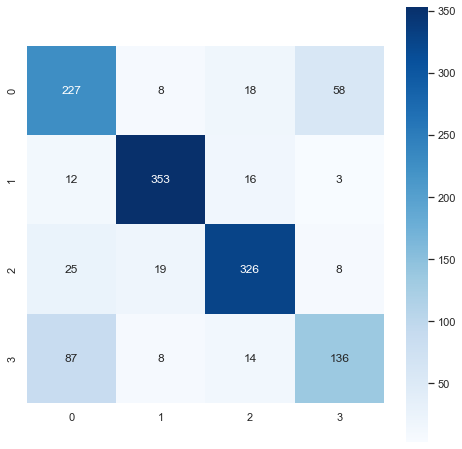

In [225]:
model.fit(xcv_train, y_train)

y_pred = model.predict(xcv_test)
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.3g')

In [226]:
# Посмотрим на ТОП 10 по важности слова в каждой категории

def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: [%s]" % (category, " ".join(feature_names[top10])))

show_top10(model, xcv_train_test, newsgroups_train.target_names)

alt.atheism: [like believe say atheism does just think don people god]
comp.graphics: [software images files data use file jpeg edu graphics image]
sci.space: [just shuttle time orbit data like earth launch nasa space]
talk.religion.misc: [say know christian think just bible don jesus people god]


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


### 2.3 [Tf-IDF](https://ru.wikipedia.org/wiki/TF-IDF)

Мешок слов не учитывает "веса" слов, он просто смотрит их вхождение в документ. Вероятно, было бы полезно взвесить каким-то обраом каждое слово в документе. Действительно, если слово встречается во всех документах, то, наверное, его вес небольшой. А если редкое слово встречается в некоторых документах, то скорее всего оно какое-то узко тематическое.

Один из способов взвесить слова - это использовать меру tf-idf, где:

**TF - term frequency** - частота слова для каждой статьи

$$\LARGE \mathrm{tf}(t,d) = \frac{n_t}{\sum_k n_k}$$

**IDF - inverse document frequency*** — обратная частота документа - уменьшает вес часто встречаемых слов

$$\LARGE \mathrm{idf}(t, D) =  \log \frac{|D|}{|\{\,d_i \in D \mid t \in d_{i}\, \}|}$$

$D$ - число документов в корпусе

$|\{\,d_i \in D \mid t \in d_{i}\, \}|$ - число документов из коллекции ${\displaystyle D}$ , в которых встречается ${\displaystyle t}$  (когда ${\displaystyle n_{t}\neq 0}$ ).

**TF-IDF**

$$\LARGE \operatorname{tf-idf}(t,d,D) = \operatorname{tf}(t,d) \times \operatorname{idf}(t, D)$$


Для него есть класс [sklearn.feature_extraction.text.TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [227]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
xTfidf_train_test = tfidf_vectorizer.fit(x_train + x_test)
xTfidf_train = tfidf_vectorizer.transform(x_train)
xTfidf_test = tfidf_vectorizer.transform(x_test)

In [228]:
model = NB()
cv(model, xTfidf_train, y_train, cv=5, scoring='accuracy')

array([0.81060606, 0.79292929, 0.80759494, 0.8278481 , 0.78227848])

                    precision    recall  f1-score   support

       alt.atheism       0.60      0.72      0.66       311
     comp.graphics       0.87      0.94      0.90       384
         sci.space       0.75      0.92      0.83       378
talk.religion.misc       0.80      0.21      0.34       245

          accuracy                           0.75      1318
         macro avg       0.75      0.70      0.68      1318
      weighted avg       0.76      0.75      0.72      1318



<AxesSubplot:>

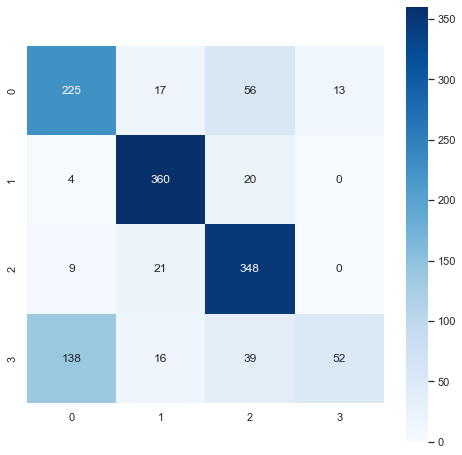

In [229]:
model.fit(xTfidf_train, y_train)

y_pred = model.predict(xTfidf_test)
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.3g')

In [230]:
show_top10(model, xTfidf_train_test, newsgroups_train.target_names)

alt.atheism: [islam does religion atheism say just think don people god]
comp.graphics: [does looking hi program know file image files thanks graphics]
sci.space: [earth lunar think just orbit moon launch like nasa space]
talk.religion.misc: [objective think just don bible christians christian people jesus god]


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


Что, если я возьму оба классификатора и сопоставлю их? Первый хорошо угадывает первый, второй и третий класс, а второй хорошо угадывает четвертый. Значит, если второй предскажет четвертый класс, мы возьмем четвертый, иначе возьмем предсказание первого.

In [271]:
model1 = NB().fit(xcv_train, y_train)
model2 = NB().fit(xTfidf_train, y_train)
y_pred1 = model1.predict(xcv_test)
y_pred2 = model2.predict(xTfidf_test)
y_pred = []
for pred1, pred2 in zip(y_pred1, y_pred2):
    if pred1 in ['comp.graphics', 'sci.space', 'talk.religion.misc'] or pred1 == pred2:
        y_pred.append(pred1)
    elif pred1 == 'alt.atheism':
        y_pred.append(pred2)

                    precision    recall  f1-score   support

       alt.atheism       0.70      0.63      0.66       311
     comp.graphics       0.88      0.93      0.90       384
         sci.space       0.80      0.90      0.85       378
talk.religion.misc       0.67      0.56      0.61       245

          accuracy                           0.78      1318
         macro avg       0.76      0.76      0.76      1318
      weighted avg       0.78      0.78      0.78      1318



<AxesSubplot:>

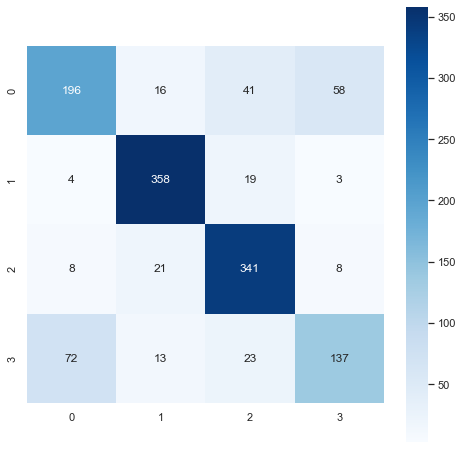

In [272]:
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.3g')

### 2.4 В чём проблема?

Как вы заметили, качество немного улучшилось. Как вы думаете почему у нас до сих пор есть ошибки? В чём проблема? Опирайтесь на вывод топа 10 важных слов, confusion matrix и репорт классификации.

**Задание**: Напишите развернутое рассуждение.

Ответ: Очень много пересекающихся слов в темах + есть тексты небольшой длины. Чем меньше длина текстов, тем меньше в них слов, тем хуже отработает классификатор.

![](https://i.imgur.com/3D5pgrk.png)

Можно еще немного улучшить качество предсказания, если использовть n-граммы, то есть не только одиночные слова, но и пары, тройки. Для этого у векторайзера есть параметр `ngram_range`, но будьте осторожны, сгенерируется очень много признаков. Их количество можно ограничить  `max_features`. Ещё можно копать в сторону правильного процессинга текстов: лемматизация и стемминг, чтобы убирать окончания, но это обчно не сильно помогает в английском языке.

Кроме того можно было бы пойти совсем в другую сторону и использовать word-2-vec технологии, тогда бы у нас слова начал "обретать" смысл. Но это вовсем другая история.